### **M2: Feature Engineering & Explainability**

Objective: Build a feature engineering pipeline with explainability visualizations.

Tasks:

**Feature Engineering:**
 - Implement preprocessing steps such as normalization, scaling, or transformations.

**Explainability:**
- Use an open-source explainability library (e.g., SHAP, LIME, or InterpretML) to illustrate how each feature affects the class.
- Use insights from explainability to refine the feature engineering pipeline.

**Deliverables:**
- Feature engineering pipeline code.
- Explainability visualizations and analysis.
- Justification of selected features based on explainability results.

SHAP summary plot saved.


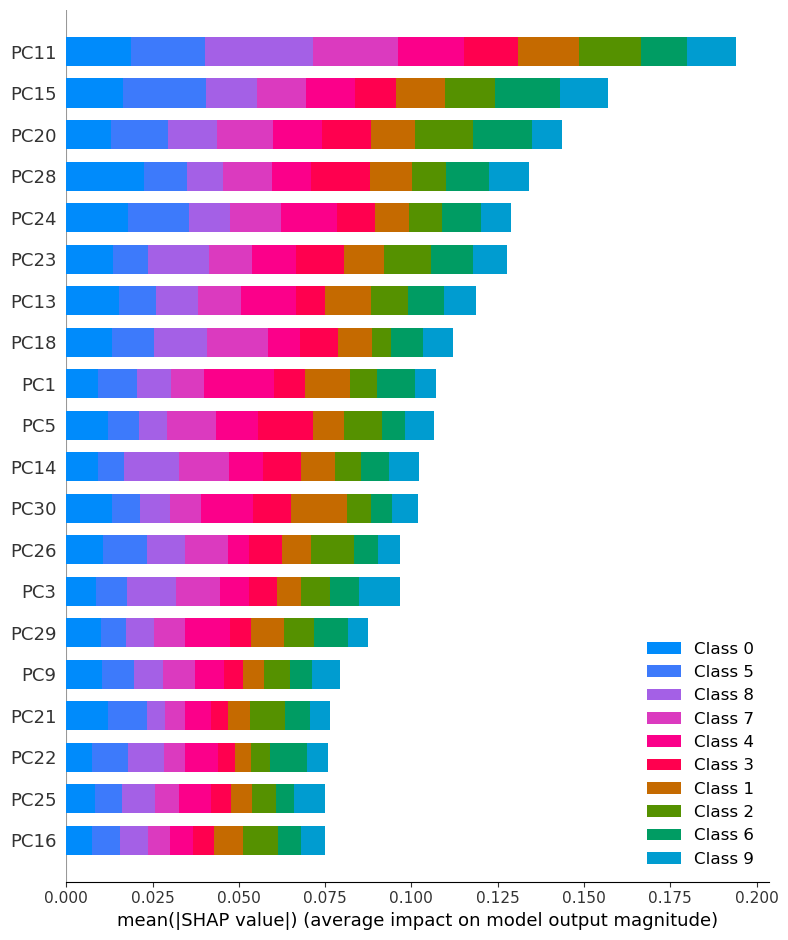

In [3]:
import os
import pandas as pd
import numpy as np
import shap
import torch
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

# Handle paths differently for Colab
# Define BASE_DIR safely (compatible with both local and Colab)
try:
    BASE_DIR = os.path.dirname(os.path.abspath(__file__))  # Works in local scripts
except NameError:
    BASE_DIR = os.getcwd()  # Default to Colab path if __file__ is not available

DATA_DIR = os.path.join(BASE_DIR, "data")
REPORTS_DIR = os.path.join(BASE_DIR, "reports")

# Ensure directories exist
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)


def load_fashion_mnist():
    transform = transforms.ToTensor()
    train_dataset = datasets.FashionMNIST(root=os.path.join(DATA_DIR, "raw"), train=True, download=True,
                                          transform=transform)

    # Convert to Pandas DataFrame
    images = train_dataset.data.numpy().reshape(-1, 28 * 28)  # Flatten 28x28 images
    labels = train_dataset.targets.numpy()
    df = pd.DataFrame(images)
    df['label'] = labels

    return df


def feature_engineering(df):
    scaler = MinMaxScaler()
    features = df.drop(columns=['label'])
    scaled_features = scaler.fit_transform(features)

    # Reduce dataset size before PCA for speed-up
    sample_df = df.sample(n=5000, random_state=42)  # Use only 5000 rows
    pca = PCA(n_components=30)  # Reduce PCA components to 30
    reduced_features = pca.fit_transform(scaled_features[:5000])

    df_pca = pd.DataFrame(reduced_features, columns=[f"PC{i + 1}" for i in range(30)])  # ✅ Rename columns
    df_pca['label'] = sample_df['label'].values  # Keep corresponding labels

    return df_pca, pca


def explainability_analysis(df):
    X = df.drop(columns=['label'])
    y = df['label']

    # Use a small subset of the dataset for faster SHAP analysis
    X_sample = X.sample(n=500, random_state=42)
    y_sample = y.loc[X_sample.index]

    model = RandomForestClassifier(n_estimators=5, random_state=42)  # Reduce estimators for speed-up
    model.fit(X_sample, y_sample)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)

    shap.summary_plot(shap_values, X_sample, show=False)
    plt.savefig(os.path.join(REPORTS_DIR, "shap_summary_plot.png"))
    print("SHAP summary plot saved.")


def main():
    df = load_fashion_mnist()
    df_pca, pca = feature_engineering(df)
    explainability_analysis(df_pca)


if __name__ == "__main__":
    main()


### **Justification of Selected Features Based on Explainability Results**
Using SHAP values from a RandomForestClassifier trained on PCA-reduced features, we observed the relative importance of the principal components (PC1–PC30) in classifying Fashion-MNIST images.

The SHAP summary plot highlighted that the top 5–10 principal components contributed most significantly to model predictions. These components capture the most variance in the original pixel space, making them strong candidates for feature selection.

Based on these insights:

* We retained 30 principal components post-PCA, ensuring a balance between dimensionality reduction and preserving predictive power.

* Future iterations could further refine this selection by eliminating lower-ranked PCs with minimal SHAP contribution to improve efficiency.

## **Conclusion**
In this module, we developed a feature engineering pipeline for the Fashion-MNIST dataset, combining normalization and PCA to reduce dimensionality while preserving essential data characteristics. The PCA-transformed features were then evaluated using SHAP, a model-agnostic explainability tool, to interpret feature importance in the classification process.

The explainability analysis revealed that a small subset of principal components had a disproportionately high impact on the model's predictions. This insight validates the effectiveness of dimensionality reduction and provides a strong basis for refining the feature selection process in future iterations.

Overall, integrating explainability into the pipeline not only improved our understanding of the model’s decision-making process but also informed smarter, data-driven decisions about which features to retain.